In [131]:
import osmnx as ox
import networkx as nx
import numpy as np
import math
from random import random
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import json
import csv

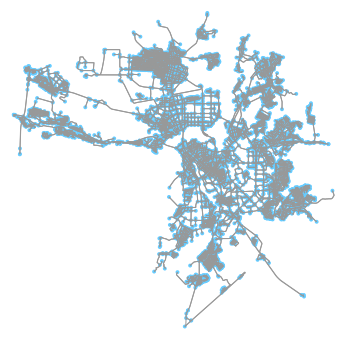

In [132]:
import matplotlib.pyplot as plt

place = {'city' : 'Kazan',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive')


fig, ax = ox.plot_graph(G)

In [3]:
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

In [4]:
from random import randint
hospitals = []
apartmentss = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartmentss.append(key)

# реализация рандомного выбора
# hospital = hospitals[randint(0, len(hospitals)-1)]
N = 100
apartments = []
# for i in range(N):
#     apartments.append(apartmentss[randint(0, len(apartmentss)-1)])

hospital = hospitals[0]
apartments = apartmentss[:N]
    
print("Больница:", hospital)
print("Дома:", apartments)

Больница: 61424274
Дома: [56255883, 56255887, 56255889, 56255891, 56255892, 56255893, 56255896, 56255897, 56255898, 56255899]


In [5]:
# нахождение ближайших узлов для объектов
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}
hosp_coord = []
aparts_coord = {}

print('Больница') 
bounds = a['geometry'][hospital].bounds
nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
hospitals_dict[hospital] = nearest_node
hosp_coord.append((bounds[1]+bounds[3])/2)
hosp_coord.append((bounds[0]+bounds[2])/2)
print(hospital, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    aparts_coord[nearest_node] = [(bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2]
    print(i, nearest_node)

Больница
61424274 738200564
------------------
Апартаменты
56255883 730355743
56255887 295857558
56255889 484260741
56255891 484260736
56255892 484260739
56255893 534317522
56255896 419830632
56255897 534317522
56255898 419830632
56255899 419830632


Скачивание матрицы смежности, заполнение ее расстояниями

In [8]:
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']}) 
            
G_pd = nx.to_pandas_adjacency(G)
G_pd = G_pd.values

nodes_list = list(G.nodes())

for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# здесь нужно где 0 заполнить гигантскими расстояниями для дальнейшего нахождения крастчайших путей
        if G_pd[i][j] == 0:
            G_pd[i][j] = 1000000
            
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [9]:
# для построения дерева кратчайших путей и нахождения длины кратчайших путей используем алгоритм Дейкстры
# N - количество узлов
# S - номер вершины, из которой начинаем путь
# matrix - матрица смежности с расстояниями между узлами (у несмежных узлов расстояние 1000000)
# pred - словарь предков со следующей структурой - {номер узла} : {номер его предка}
def dijkstra(N, S, matrix, pred):
    valid = [True]*N
    weight = [1000000]*N
    weight[S] = 0
    for i in range(N):
        min_weight = 1000001
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
                for z in range(N):
                    if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                        weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                        pred[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight

In [10]:
hospital_value = list(hospitals_dict.values())[0]
apartments_values = list(apartments_dict.values())

In [11]:
# nodes_numbers

In [12]:
p = {}
d = dijkstra(len(G_pd), nodes_numbers[hospital_value], G_pd, p)
# print(d)

### Сумма кратчайших расстояний от объекта до всех заданных узлов

In [13]:
def find_short_path(pred_dict, index_a, index_b):
    path = []
    if index_a != index_b:
        path.append(index_b)
        temp = index_b
        while pred_dict[temp] != index_a:
            path.append(pred_dict[temp])
            temp = pred_dict[temp]
        path.append(index_a)
        path.reverse()
    return path

In [14]:
nodes_numbers[hospital_value]

1329

In [15]:
short_paths = {}
short_paths_len = 0
for i in apartments_values:
    path = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[i])
    short_paths[nodes_numbers[i]] = path
    short_paths_len += d[nodes_numbers[i]]

#### Дерево кратчайших путей (изображение на графе)

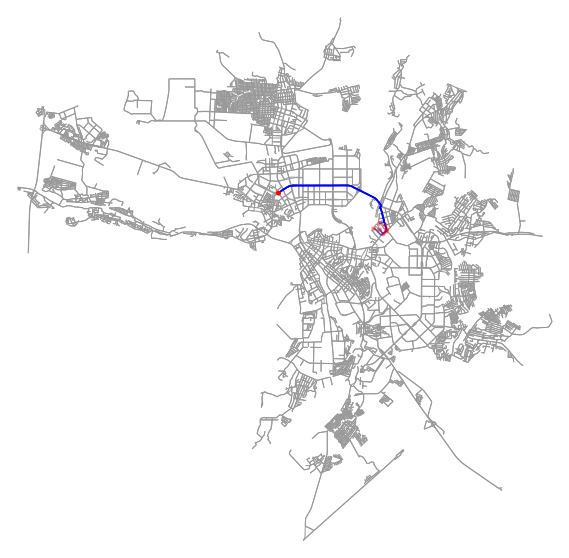

In [129]:
draw_paths = []
for i in short_paths.values():
    draw_paths.append(i)

routes = []
for i in draw_paths:
    route = []
    route_colors = []
    node_colors = []
    for j in i:
        key = get_key(nodes_numbers, j)
        route.append(key) 
    routes.append(route)

fig, ax = ox.plot_graph_routes(G, routes, route_color='b', node_size = 0, fig_height = 10, fig_width = 10, orig_dest_node_color  = 'r', orig_dest_node_size = 20, route_linewidth = 1.5, save = True, file_format='png', filename='short_path_tree_task2')
plt.show()

In [16]:
# искомая сумма
short_paths_len

89260.22099342284

### Общая длина дерева от объекта до всех заданных узлов

In [17]:
def tree_weight(tree, matrix, aparts):
    weight = 0
    for i in aparts:
        if i in tree.keys():
            j = tree[i]
            weight += matrix[j][i]
    return weight

In [18]:
aparts = []
for i in apartments_values:
    aparts.append(nodes_numbers[i])
short_path_tree_weight = tree_weight(p, G_pd, aparts)

In [19]:
# искомая длина
short_path_tree_weight

2672.319000000001

### Ищем матрицу кратчайших расстояний между узлами

In [20]:
new_nodes = apartments_values

In [21]:
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

In [22]:
# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_aparts = {}

index_nodes = [] # индексы узлов домов и квартир! и только их!
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узл

In [23]:
index_nodes

[2499, 4846, 6373, 6368, 6371, 1131, 2937, 1131, 2937, 2937]

In [24]:
for i in range(len(new_nodes)):
    pred = {}
    index = index_nodes[i]
    distance = dijkstra(len(G_pd), index, G_pd, pred)
    pred_aparts[index] = pred
    for j in range(len(new_nodes)):
        short_path_matrix[i][j] = distance[index_nodes[j]]
        
# print(short_path_matrix) 

[[   0.     499.162 1031.257 1130.859  909.707 1880.485 1429.275 1880.485
  1429.275 1429.275]
 [ 499.162    0.     532.095  631.697  410.545 1381.323  930.113 1381.323
   930.113  930.113]
 [ 797.45   298.288    0.     546.246  288.922 1295.872  844.662 1295.872
   844.662  844.662]
 [1146.708  647.546  349.258    0.     227.708  784.492  333.282  784.492
   333.282  333.282]
 [ 919.     419.838  121.55   257.324    0.    1006.95   555.74  1006.95
   555.74   555.74 ]
 [3155.552 2656.39  2358.102 2008.844 2236.552    0.    2342.126    0.
  2342.126 2342.126]
 [1479.99   980.828  682.54   333.282  560.99  1082.908    0.    1082.908
     0.       0.   ]
 [3155.552 2656.39  2358.102 2008.844 2236.552    0.    2342.126    0.
  2342.126 2342.126]
 [1479.99   980.828  682.54   333.282  560.99  1082.908    0.    1082.908
     0.       0.   ]
 [1479.99   980.828  682.54   333.282  560.99  1082.908    0.    1082.908
     0.       0.   ]]


In [ ]:
# Записываем матрицу кратчайших расстояний в csv файл

def csv_writer(data, path):
    """
    Write data to a CSV file path
    """
    with open(path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in data:
            writer.writerow(line)

data = short_path_matrix
path = "matrix_task2.csv"
csv_writer(data, path)

## Кластеризация

In [25]:
# создаем верхнетреугольную матрицу для построения кластеров по следующему принципу:
# смотрим расстояния на симметричных местах и добавляем минимальное
# наша верхнетреугольная матрица выглядит как список
matrix_cluster = []
for i in range(len(short_path_matrix)):
    for j in range(i + 1, len(short_path_matrix)):
        if short_path_matrix[i][j] < short_path_matrix[j][i]:
            matrix_cluster.append(short_path_matrix[i][j])
        else:
            matrix_cluster.append(short_path_matrix[j][i])
            
# print(matrix_cluster)       

[499.16200000000003, 797.45, 1130.8590000000002, 909.7070000000001, 1880.4850000000004, 1429.275, 1880.4850000000004, 1429.275, 1429.275, 298.288, 631.697, 410.545, 1381.323, 930.113, 1381.323, 930.113, 930.113, 349.258, 121.55, 1295.8720000000003, 682.54, 1295.8720000000003, 682.54, 682.54, 227.708, 784.4920000000002, 333.282, 784.4920000000002, 333.282, 333.282, 1006.9500000000002, 555.74, 1006.9500000000002, 555.74, 555.74, 1082.9080000000001, 0.0, 1082.9080000000001, 1082.9080000000001, 1082.9080000000001, 0.0, 0.0, 1082.9080000000001, 1082.9080000000001, 0.0]


## Задание 2 
#### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-
linkage clustering).

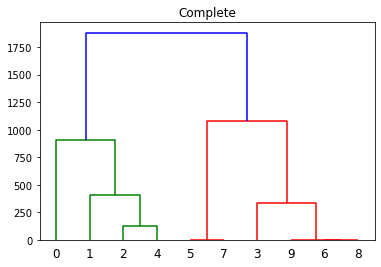

In [26]:
Z = linkage(matrix_cluster, 'complete')

plt.title('Complete')
dendrogram(Z)
plt.show()

#### Пункт 3
Разбиваем узлы на k кластеров.
k=2, 3, 5

In [27]:
# разбиваем на 2 кластера
num_clust = 2
Z2 = fcluster(Z, num_clust, 'maxclust')
Z2

array([1, 1, 1, 2, 1, 2, 2, 2, 2, 2], dtype=int32)

In [28]:
# разбиваем на 3 кластера
num_clust = 3
Z3 = fcluster(Z, num_clust, 'maxclust')
Z3

array([1, 1, 1, 3, 1, 2, 3, 2, 3, 3], dtype=int32)

In [29]:
# разбиваем на 5 кластеров
num_clust = 5
Z5 = fcluster(Z, num_clust, 'maxclust')
Z5

array([3, 2, 1, 5, 1, 4, 5, 4, 5, 5], dtype=int32)

In [ ]:
# записываем информацию о разбиении на кластеры в csv файл
data = Z2
path = "cluster2.csv"
csv_writer(data, path)

data = Z3
path = "cluster3.csv"
csv_writer(data, path)

data = Z5
path = "cluster5.csv"
csv_writer(data, path)

### Ищем центроиды и деревья кратчайших расстояний для кластеров c k = 2

##### а) Найдем координаты центроидов для каждого кластера и ближайшие к ним узлы

In [30]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

In [69]:
c1 = [0, 0]
c2 = [0, 0]
k1 = 0
k2 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z2)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z2[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средниъ координат
        k1 += 1
    else:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
print("Coordinates: ", c1, c2)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))

print("Nodes: ", center1, center2)

Coordinates:  [55.80406612499999, 49.1822702] [55.80313733333333, 49.17835015833334]
Nodes:  730355768 419830632


#####  b) Найдем кратчайшие пути от объекта до центроидов и сумму этих кратчайших расстояний

In [70]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])

In [71]:
# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_paths = len_path1 + len_path2
len_paths

17752.687998684567

In [119]:
def draw_short_path(graph, path, height, width):
    route = []
    for i in path:
        key = get_key(nodes_numbers, i)
        route.append(key)      
    ox.plot_graph_route(graph, route, node_size = 0, fig_height=height, fig_width=width)

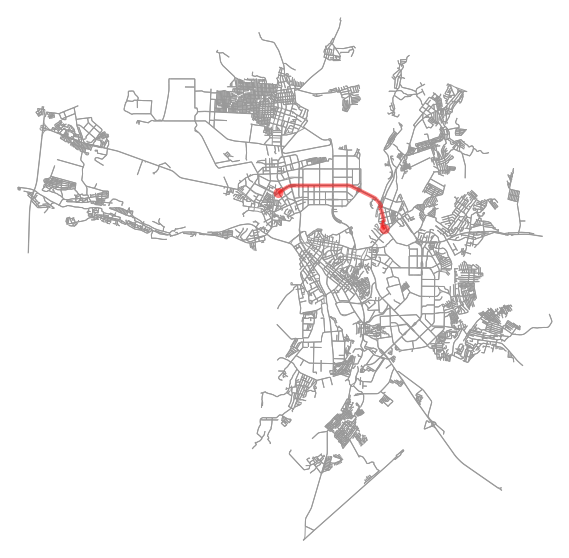

In [120]:
# Нарисуем кратчайший путь из объекта до первого центроида
draw_short_path(G, path1, 10, 10)

#####  b) Построим дерево кратчайших путей от объекта до центроидов и вычислим его длину

In [72]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
short_path_tree_centers = tree_weight(p, G_pd, centers)

In [73]:
# длина дерева кратчайшиъ путей из объекта до центроидов
short_path_tree_centers

568.1780000000001

#####  c) Считаем кратчайшие пути от каждого центроида до остальных узлов кластера

In [74]:
p1 = {}
p2 = {}
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)

In [75]:
nodes_c1 = []
nodes_c2 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_len_c1 = 0
short_paths_len_c2 = 0
for i in range(len(Z2)):
    if Z2[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
        

Сумма кратчайших путей от первого центроида до остальных узлов кластера

In [76]:
short_paths_len_c1

2795.56

Сумма кратчайших путей от второго центроида до остальных узлов кластера

In [77]:
short_paths_len_c2

2499.098

#####  Посчитаем длину деревьев кратчайших расстояний из центроидов

In [78]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
short_path_tree_weight_c1

456.89000000000004

In [79]:
nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
short_path_tree_weight_c2

1253.9030000000002

##### d) Длина дерева кратчайших путей от объекта до узлов кластеров

In [80]:
tree_sum1 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2
tree_sum1

2278.9710000000005

##### d) Сумма кратчайших путей от объекта до узлов кластеров

In [81]:
paths_sum1 = short_paths_len_c1 + short_paths_len_c2 + len_paths
paths_sum1

23047.345998684566

#### Аналогичные действия выполняем для k = 3 и k = 5

### Ищем центроиды и деревья кратчайших расстояний кластеров c k = 3

In [41]:
c1 = [0, 0]
c2 = [0, 0]
c3 = [0, 0]
k1 = 0
k2 = 0
k3 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z3)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z3[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средниъ координат
        k1 += 1
    elif Z3[i] == 2:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
    else:
        c3[0] += coords[0]
        c3[1] += coords[1]
        k3 += 1

# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
for k in range(len(c3)):
    c3[k] /= k3
print("Coordinates: ", c1, c2, c3)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))
center3 = ox.get_nearest_node(G, (c3[0], c3[1]))

print("Nodes: ", center1, center2, center3)

Coordinates:  [55.80406612499999, 49.1822702] [55.803166149999996, 49.1754653] [55.803122925, 49.1797925875]
Nodes:  730355768 534317522 419830632


In [42]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])
path3 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center3])

# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_path3 = d[nodes_numbers[center3]]
len_paths = len_path1 + len_path2 + len_path3
len_paths

27333.951998026852

In [43]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
centers.append(nodes_numbers[center3])
short_path_tree_centers = tree_weight(p, G_pd, centers)

# длина дерева кратчайшиъ путей из объекта до центроидов
short_path_tree_centers

1186.413

In [44]:
p1 = {}
p2 = {}
p3 = {}
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)
d3 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p3)

In [45]:
nodes_c1 = []
nodes_c2 = []
nodes_c3 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_c3 = {}
short_paths_len_c1 = 0
short_paths_len_c2 = 0
short_paths_len_c3 = 0
for i in range(len(Z3)):
    if Z3[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    elif Z3[i] == 2:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c3.append(i)
        path_c3 = find_short_path(p3, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c3[nodes_numbers[apartments_values[i]]] = path_c3
        short_paths_len_c3 += d3[nodes_numbers[apartments_values[i]]]

In [46]:
short_paths_len_c1

2795.56

In [47]:
short_paths_len_c2

0

In [48]:
short_paths_len_c3

9035.222

In [49]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
print(short_path_tree_weight_c1)

nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
print(short_path_tree_weight_c2, nodes)

nodes = []
for i in nodes_c3:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c3 = tree_weight(p3, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c3)

456.89000000000004
0 [1131, 1131]
1341.6870000000004


In [50]:
tree_sum2 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2 + short_path_tree_weight_c3
tree_sum2

2984.9900000000007

In [51]:
paths_sum2 = short_paths_len_c1 + short_paths_len_c2 + short_paths_len_c3 + len_paths
paths_sum2

39164.73399802685

### Ищем центроиды и деревья кратчайших расстояний для кластеров с k = 5

In [52]:
c1 = [0, 0]
c2 = [0, 0]
c3 = [0, 0]
c4 = [0, 0]
c5 = [0, 0]
k1 = 0
k2 = 0
k3 = 0
k4 = 0
k5 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z5)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z5[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средних координат
        k1 += 1
    elif Z5[i] == 2:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
    elif Z5[i] == 3:
        c3[0] += coords[0]
        c3[1] += coords[1]
        k3 += 1
    elif Z5[i] == 4:
        c4[0] += coords[0]
        c4[1] += coords[1]
        k4 += 1
    else:
        c5[0] += coords[0]
        c5[1] += coords[1]
        k5 += 1

# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
for k in range(len(c3)):
    c3[k] /= k3
for l in range(len(c4)):
    c4[l] /= k4
for m in range(len(c5)):
    c5[m] /= k5
print("Coordinates: ", c1, c2, c3, c4, c5)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))
center3 = ox.get_nearest_node(G, (c3[0], c3[1]))
center4 = ox.get_nearest_node(G, (c4[0], c4[1]))
center5 = ox.get_nearest_node(G, (c5[0], c5[1]))

print("Nodes: ", center1, center2, center3, center4, center5)

Coordinates:  [55.80268905, 49.185138699999996] [55.8052043, 49.18371535] [55.8056821, 49.17508805] [55.803166149999996, 49.1754653] [55.803122925, 49.1797925875]
Nodes:  292927335 295857558 730355743 534317522 419830632


In [53]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])
path3 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center3])
path4 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center4])
path5 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center5])

# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_path3 = d[nodes_numbers[center3]]
len_path4 = d[nodes_numbers[center4]]
len_path5 = d[nodes_numbers[center5]]
len_paths = len_path1 + len_path2 + len_path3 + len_path4 + len_path5
len_paths

43837.08899671142

In [54]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
centers.append(nodes_numbers[center3])
centers.append(nodes_numbers[center4])
centers.append(nodes_numbers[center5])
short_path_tree_centers = tree_weight(p, G_pd, centers)

# длина дерева кратчайшиъ путей из объекта до центроидов
short_path_tree_centers

1657.7760000000003

In [61]:
p1 = {}
p2 = {}
p3 = {}
p4 = {}
p5 = {}
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)
d3 = dijkstra(len(G_pd), nodes_numbers[center3], G_pd, p3)
d4 = dijkstra(len(G_pd), nodes_numbers[center4], G_pd, p4)
d5 = dijkstra(len(G_pd), nodes_numbers[center5], G_pd, p5)

In [62]:
nodes_c1 = []
nodes_c2 = []
nodes_c3 = []
nodes_c4 = []
nodes_c5 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_c3 = {}
short_paths_c4 = {}
short_paths_c5 = {}

short_paths_len_c1 = 0
short_paths_len_c2 = 0
short_paths_len_c3 = 0
short_paths_len_c4 = 0
short_paths_len_c5 = 0

for i in range(len(Z5)):
    if Z5[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 2:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 3:
        nodes_c3.append(i)
        path_c3 = find_short_path(p3, nodes_numbers[center3], nodes_numbers[apartments_values[i]])
        short_paths_c3[nodes_numbers[apartments_values[i]]] = path_c3
        short_paths_len_c3 += d3[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 4:
        nodes_c4.append(i)
        path_c4 = find_short_path(p4, nodes_numbers[center4], nodes_numbers[apartments_values[i]])
        short_paths_c4[nodes_numbers[apartments_values[i]]] = path_c4
        short_paths_len_c4 += d4[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c5.append(i)
        path_c5 = find_short_path(p5, nodes_numbers[center5], nodes_numbers[apartments_values[i]])
        short_paths_c5[nodes_numbers[apartments_values[i]]] = path_c5
        short_paths_len_c5 += d5[nodes_numbers[apartments_values[i]]]

In [63]:
print(short_paths_len_c1, short_paths_len_c2, short_paths_len_c3, short_paths_len_c4, short_paths_len_c5)

157.722 0 0 0 333.282


In [64]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
print(short_path_tree_weight_c1)

nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
print(short_path_tree_weight_c2)

nodes = []
for i in nodes_c3:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c3 = tree_weight(p3, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c3)

nodes = []
for i in nodes_c4:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c4 = tree_weight(p4, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c4)

nodes = []
for i in nodes_c5:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c5 = tree_weight(p5, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c5)

139.636
0
0
0
17.433


In [65]:
tree_sum3 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2 + short_path_tree_weight_c3 + short_path_tree_weight_c4 + short_path_tree_weight_c5
tree_sum3

1814.8450000000003

In [66]:
paths_sum3 = short_paths_len_c1 + short_paths_len_c2 + short_paths_len_c3 + short_paths_len_c4 + short_paths_len_c5 + len_paths
paths_sum3

44328.09299671142

### Сравнение результатов

In [82]:
print("Длина дерева кратчайших путей")
print("Без кластеризации: ", short_path_tree_weight)
print("2 кластера: ", tree_sum1)
print("3 кластера: ", tree_sum2)
print("5 кластеров: ", tree_sum3)

Длина дерева кратчайших путей
Без кластеризации:  2672.319000000001
2 кластера:  2278.9710000000005
3 кластера:  2984.9900000000007
5 кластеров:  1814.8450000000003


In [83]:
print("Общая сумма кратчайших путей")
print("Без кластеризации: ", short_paths_len)
print("2 кластера: ", paths_sum1)
print("3 кластера: ", paths_sum2)
print("5 кластеров: ", paths_sum3)

Общая сумма кратчайших путей
Без кластеризации:  89260.22099342284
2 кластера:  23047.345998684566
3 кластера:  39164.73399802685
5 кластеров:  44328.09299671142
